<a href="https://colab.research.google.com/github/bloup1/Deep-Learning/blob/main/Summative_assessment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning
## Summative assessment
### Coursework 3

#### Instructions

This coursework is released on **Wednesday 20th March 9.00** and is due by **Wednesday 24th April 23.59**. It is worth **50%** of your overall mark. There are 4 questions in this assessment, and a total of 100 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks per question below, an additional 5 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a generative deep learning model for a spoken audio dataset.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file), PDF report and model submission.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF/HTML copy of your executed notebook, in case the .ipynb file is corrupted for some reason.

Upload a zip file containing your notebook, separate PDF/HTML file(s), model(s) and any other relevant files to Coursera by the deadline above.

This assignment must be attempted individually; your submission must be your own, unaided work. Candidates are prohibited from discussing assessed coursework, and must abide by [Imperial College’s rules](https://www.imperial.ac.uk/media/imperial-college/administration-and-support-services/registry/academic-governance/public/academic-policy/academic-integrity/Examination-and-assessments---academic-integrity.pdf) regarding academic integrity and plagiarism. Unless specifically authorised within the assignment instructions, the submission of output from [generative AI tools](https://www.imperial.ac.uk/about/leadership-and-strategy/provost/vice-provost-education/generative-ai-tools-guidance/) (e.g., ChatGPT) for assessed coursework is prohibited. Violations will be treated as an examination offence. Enabling other candidates to plagiarise your work constitutes an examination offence. To ensure quality assurance is maintained, departments may choose to invite a random selection of students to an ‘authenticity interview’ on their submitted assessments.

In [1]:
! pip install pydub==0.25.1 -q

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import os
from IPython.display import Audio, display

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer

In [3]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Files.zip", 'r')
zip_ref.extractall("/cswk3")
zip_ref.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### The Free Spoken Digit Dataset (FSDD)

This assessment makes use of the [Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset). This dataset consists of recordings of spoken digits by a number of different speakers, all recorded at a sample rate of 8kHz. The recordings are trimmed so that they have near minimal silence at the beginnings and ends.

For this assessment, we will use the version of the dataset made available through TensorFlow Datasets ([https://www.tensorflow.org/datasets/catalog/spoken_digit](https://www.tensorflow.org/datasets/catalog/spoken_digit)).

The dataset consists 2,500 recordings from 5 different speakers. Using the TensorFlow Datasets API, this dataset can be downloaded and stored directly in a Dataset object using the code below.

In [5]:
ds_train, ds_val, ds_test = tfds.load(
    'spoken_digit',
    split=['train[:60%]','train[60%:80%]','train[80%:]'],
    data_dir=os.path.join( "data", "spoken_digit"),
    shuffle_files=True
)

ds_whole = tfds.load(
    'spoken_digit',
    split='train',
    data_dir=os.path.join("data", "spoken_digit"),
    shuffle_files=True
)


In [6]:
ds_train.element_spec

{'audio': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'audio/filename': TensorSpec(shape=(), dtype=tf.string, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}

#### VQ-VAE

The VQ-VAE was first developed in the following paper:

* van den Oord, A., Vinyals, O. & Kavukcuoglu, K. (2017), "Neural discrete representation learning", _Proceedings of the 31st International Conference on Neural Information Processing Systems_, 6309-6318.

In this assessment you will develop and train a vector-quantised variational autoencoder (VQ-VAE) model. This is a variant of the VAE algorithm that makes use of a discrete latent space. In particular, the VQ-VAE defines a _codebook_ $\mathbf{e} \in \mathbb{R}^{K \times D}$ for the latent embedding space, consisting of $K$ latent embedding vectors $e_i$ ($i=1,\ldots,K$), each of dimension $D$. The algorithm involves training encoder and decoder networks as usual. However, for a given input $x$, the encoder output $E(x) \in \mathbb{R}^D$ is quantised to the nearest latent embedding vector:

$$VQ(E(x)) = e_k,\quad\textrm{where }k = \underset{j}{\arg\min}||E(x) - e_j||_2,$$

where the $||\cdot||_2$ norm above is the Euclidean norm in $\mathbb{R}^D$. This quantized latent vector is then passed through the decoder to output the likelihood $p_\theta(x \mid z)$ as usual.

The quantisation stage of the VQ-VAE means that it is not possible to compute gradients with respect to the encoder variables. The solution to this problem in the VQ-VAE is to use the _straight through estimator_, in which the gradients computed with respect to the quantised embeddings are simply passed unaltered to the encoder. This process means that the codebook embeddings $e_i$ do not receive any gradient updates (for details, refer to the implementation referenced in question 3, which makes this process explicit). The VQ-VAE objective therefore adds two additional terms to learn the codebook embeddings:

$$
L = \mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z) ] + ||\textrm{sg}[E(x)] - VQ(E(x))||^2_2 + \beta || E(x) - \textrm{sg}[VQ(E(x))]||_2^2
$$

In the above, $\textrm{sg}$ is the _stop gradient_ operator that is defined as identity in the forward pass but has zero partial derivates (see [`tf.stop_gradient`](https://www.tensorflow.org/api_docs/python/tf/stop_gradient)). This means that when evaluating the loss function above, the stop gradient operator can be ignored, but when computing derivatives of the loss with respect to the model parameters, the partial derivatives of $\textrm{sg}[E(x)]$ and $\textrm{sg}[VQ(E(x))]$ with respect to the model parameters will be zero. The constant $\beta$ is usually taken set to $\beta=0.25$ by default, as in the original paper.

The first term in the objective $L$ above is the reconstruction loss, the second term is the _codebook loss_, and the third term is the _commitment loss_. The Kullback-Leibler divergence term in the ELBO is constant and so is ignored for training.

In this assessment, you will design, implement, train and evaluate a VQ-VAE for the spoken digit dataset, and use it to learn a generative model of the spoken audio.

### Question 1 (Total 15 marks)

The loaded Dataset returns a dictionary with keys `"audio"`, `"audio/filename"` and `"label"`. For this assessment you will only need the `"audio"` entry, and the other entries can be discarded.

In this question, you should carry out a basic exploration and analysis of the dataset; computing, displaying and visualising any properties you deem to be relevant. You can also use comments and/or markdown as appropriate.

All of the Dataset preparation/preprocessing for question 2a) should be done in this question, so that it is ready for training the VQ-VAE.

_Hint: an audio file can be played within a jupyter notebook using the `Audio` class from the `IPython.display` module (imported above). See [here](https://ipython.org/ipython-doc/3/api/generated/IPython.display.html) for usage._

**(15 marks)**

In [7]:
! pip install librosa
! pip install tensorflow_io
import librosa


In [8]:
# https://www.kaggle.com/datasets/joserzapata/free-spoken-digit-dataset-fsdd/code
# https://www.kaggle.com/code/holzner/variational-autoencoder-for-speech-dataset
# https://www.youtube.com/watch?v=UGTAzMX3vjQ

# visualize the data and padding:
# https://keras.io/examples/audio/ctc_asr/

# masking
# https://source-separation.github.io/tutorial/training/building_blocks.html



In [57]:
import librosa

def max_sound(data):
    return tf.math.reduce_max(data['audio'])

def min_sound(data):
    return tf.math.reduce_min(data['audio'])

def max_length(data):
    return tf.gather(tf.shape(data['audio']),0)

# no need to have global max
global_max_sound = np.max(np.array([a.numpy() for a in list(ds_whole.map(max_sound))]))
global_min_sound = np.min(np.array([a.numpy() for a in list(ds_whole.map(min_sound))]))
global_max_length = np.max(np.array([a.numpy() for a in list(ds_whole.map(max_length))]))

print("The highest length is {}.".format(global_max_length))

batch_size = 64

padding = tf.constant([[0, 0,], [0, 1]])

nfft = 1024
window = 1024
stride = 128

# Process the data
def process_sounds_spec(data):
    audio = data['audio']
    audio_length = tf.size(audio)
    #t = tf.constant([1, 2, 3])
    t = audio[tf.newaxis,...]
    paddings = padding*(global_max_length-audio_length) #tf.constant([[0, 0,], [0, global_max_length-audio_length]])
    padded_sound = tf.squeeze(tf.pad(t, paddings, "CONSTANT"))
    #padded_sound = np.pad(audio,(0,global_max_length-audio_length),'constant')
    cast_sound = tf.cast(padded_sound, tf.float32)
    spec = tf.transpose(tf.transpose(tfio.audio.spectrogram(cast_sound,
                                                            nfft=nfft,
                                                            window=window,
                                                            stride=stride))[:-1])
    spec[...,tf.newaxis]
    max_spec = tf.math.reduce_max(spec)
    min_spec = tf.math.reduce_min(spec)
    ((spec[...,tf.newaxis]-min_spec)/(max_spec-min_spec))
    return spec[...,tf.newaxis], min_spec, max_spec

def process_sounds_minmax(data1,data2,data3):
    return data2,data3


################### remove the +2 in global_max_length

sound_max_length_padded = global_max_length+2

def process_sounds(data):
    audio = data['audio']
    audio_length = tf.size(audio)
    #t = tf.constant([1, 2, 3])
    audio_ext = audio[tf.newaxis,...]
    paddings = padding*(sound_max_length_padded-audio_length) #tf.constant([[0, 0,], [0, global_max_length-audio_length]])
    padded_sound = tf.squeeze(tf.pad(audio_ext, paddings, "CONSTANT"))
    #padded_sound = np.pad(audio,(0,global_max_length-audio_length),'constant')
    cast_sound = tf.cast(padded_sound, tf.float32)
    max_sound = tf.math.reduce_max(cast_sound)
    min_sound = tf.math.reduce_min(cast_sound)
    normalized = ((cast_sound-min_sound)/(max_sound-min_sound))
    return normalized[...,tf.newaxis]

def process_sounds_no_pad(data):
    audio = data['audio']
    cast_sound = tf.cast(audio, tf.float32)
    max_sound = tf.math.reduce_max(cast_sound)
    min_sound = tf.math.reduce_min(cast_sound)
    normalized = ((cast_sound-min_sound)/(max_sound-min_sound))
    return normalized[...,tf.newaxis]

#spec_min_max_ds = ds_train.map(process_sounds_spec)
#min_max_list = list(spec_min_max_ds.map(process_sounds_minmax).as_numpy_iterator())


#train_dataset = ds_train.map(process_sounds).shuffle(500).padded_batch(64).prefetch(tf.data.AUTOTUNE)
#val_dataset = ds_val.map(process_sounds).shuffle(500).padded_batch(64).prefetch(tf.data.AUTOTUNE)
#test_dataset = ds_test.map(process_sounds).shuffle(500).padded_batch(64).prefetch(tf.data.AUTOTUNE)

#train_dataset = ds_train.map(process_sounds)

train_dataset = ds_train.shuffle(500).map(process_sounds).batch(64).prefetch(tf.data.AUTOTUNE)
train_dataset_nopad = ds_train.map(process_sounds_no_pad)
val_dataset = ds_val.map(process_sounds).shuffle(500).batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = ds_test.map(process_sounds).shuffle(500).batch(64).prefetch(tf.data.AUTOTUNE)



The highest length is 18262.


In [10]:
list_array = []
for elem in train_dataset:
    list_array.append(np.squeeze(elem.numpy()))

data_variance = np.var(np.concatenate(list_array, axis=0))
data_variance

0.0068139816

In [11]:
list_array = []
for elem in train_dataset_nopad:
    list_array.append(np.squeeze(elem.numpy()))

data_variance_nopadding = np.var(np.concatenate(list_array, axis=0))
data_variance_nopadding

0.01663708

In [ ]:
for elem in train_dataset.take(2):
    print(elem.shape)

(64, 18264, 1)
(64, 18264, 1)


In [ ]:
Audio(elem[0],rate=8000)

In [ ]:
Audio(audioBack,rate=8000)

In [ ]:
(global_max_sound,global_min_sound)

(32767, -32768)

#### EDA Attempt

In [11]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from os import listdir
from os.path import join
from scipy.io import wavfile
import IPython.display as ipd
from librosa.effects import trim # trimming signal
X = []
for data in ds_whole:
    X.append(data['audio'].numpy())

In [ ]:
X[0]

array([   0,    0, -256, ..., -512, -256, -512])

In [ ]:
def show_length_distribution(signals, rate = 8000):
    sampel_times = [len(x)/rate for x in signals]
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})
    # Add a graph in each part
    sns.boxplot(x = sampel_times, ax=ax_box, linewidth = 0.9, color=  '#9af772')
    sns.histplot(x = sampel_times, ax=ax_hist, bins = 'fd', kde = True)
    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    title = 'Audio signal lengths'
    x_label = 'duration (seconds)'
    y_label = 'count'

    plt.suptitle(title)
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel(y_label)
    plt.show()
    return sampel_times

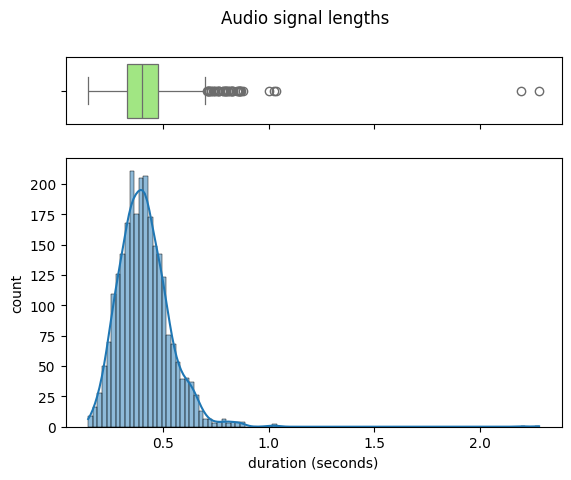

In [ ]:
a = show_length_distribution(X)

In [ ]:
# show longest signal

# show shortest signal

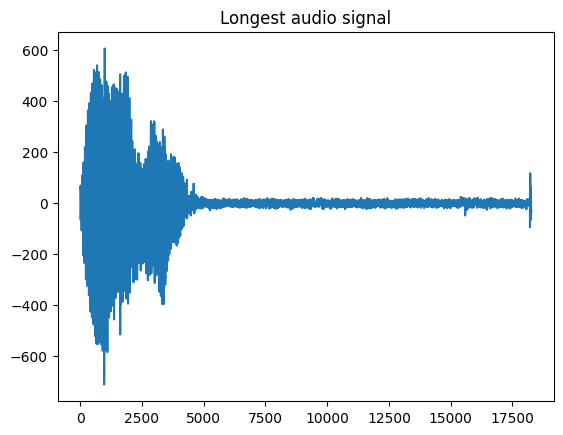

In [ ]:
rate = 8000
Longest_audio = np.argmax([len(x) for x in X])
plt.plot(X[Longest_audio])
plt.title("Longest audio signal");


ipd.Audio(X[Longest_audio], rate=rate)

# https://www.kaggle.com/code/nagarmanthan/audio-processing-eda/notebook

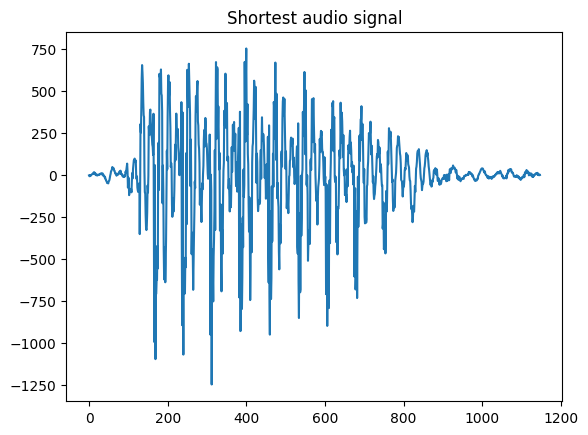

In [ ]:
Shortest_audio = np.argmin([len(x) for x in X])
plt.plot(X[Shortest_audio])
plt.title("Shortest audio signal");

ipd.Audio(X[Shortest_audio], rate=rate)

In [ ]:
X[Longest_audio][-5:]

array([  7,   6, -28, -39, -30])

In [ ]:
# by default anything below 10 db is considered as silence
def remove_silence(sample, sr= 8000, top_db = 10):
    """This function removes trailing and leading silence periods of audio signals.
    """
    y = np.array(sample, dtype = np.float64)
    # Trim the beginning and ending silence
    yt, _ = trim(y, top_db= top_db)
    return yt

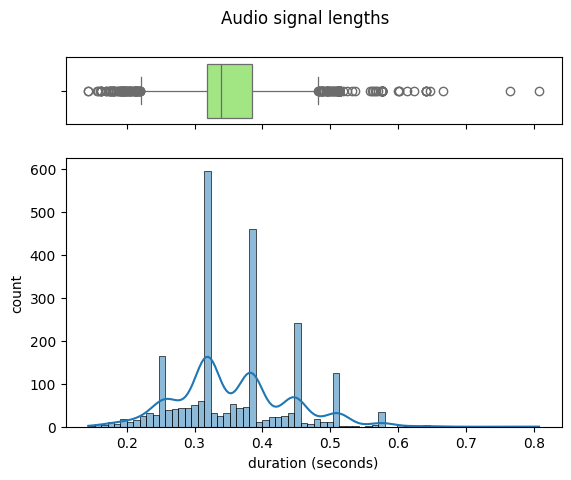

In [ ]:
X_tr = [remove_silence(x) for x in X]

show_length_distribution(X_tr);

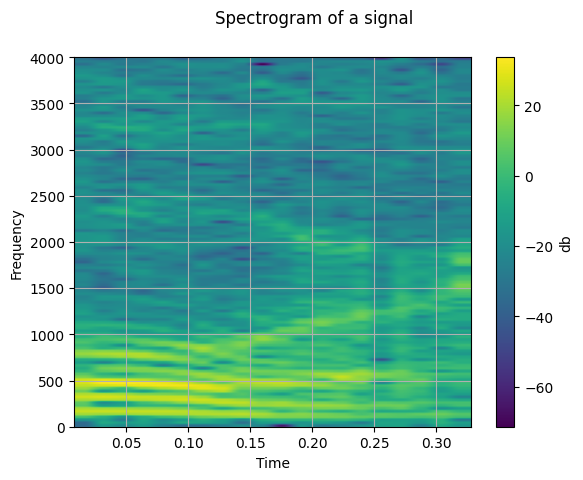

In [ ]:
# Plotting the Frequency Spectrum of the signal
# Plot the spectrogram of power on log scale

# fig, ax = plt.subplots(figsize = (8,6))

powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(X[np.random.randint(100)], Fs=rate, scale = "dB")
cbar = plt.gcf().colorbar(imageAxis)
cbar.set_label('db')
plt.grid()
plt.suptitle("Spectrogram of a signal")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()


### Question 2 (Total 25 marks)

a) In the VQ-VAE, the variational posterior output by the encoder is deterministic:

$$q_\phi(z = e_k \mid x) = \left\{
\begin{array}{l}
~1 \quad\textrm{for}\quad k=\underset{j}{\arg\min} ||E(x) - e_j||\\
~0 \quad\textrm{otherwise}
\end{array}
\right.
$$

where in the above, $\phi$ represents the parameters of the encoder. Show that by choosing a simple uniform distribution over the codebook vectors $e_i$ as the prior distribution $p(z)$, the KL-divergence term of the ELBO objective is equal to a constant.

**(5 marks)**

We have


\begin{align}
D_{KL}\left( q_\phi({z}\mid{x}) || p_\theta({z}) \right) = \sum_{k}^{K} q_\phi(z = e_k\mid x)\log\left(\frac{q_\phi({z = e_k}\mid{x})}{p_\theta({z})}\right)
\end{align}

And we know that  $p_{\theta(z)}=\frac{1}{K}$ Therefore we have:

\begin{align}
D_{KL}\left( q_\phi({z}\mid{x}) || p_\theta({z}) \right) &= \log(K) \ \sum_{k}^{K} q_\phi(z = e_k\mid{x}) +  \sum_{k}^{K} q_\phi(z = e_k\mid x)\log\left(q_\phi(z = e_k \mid x)\right) \\
& = \log(K) + 0 = \log(K) \text{ since } f(u) = u \log(u) \text{ is zero at } x=0
\end{align}

$

b) The VQ-VAE as described above has an implementation that is available on the Keras website [here](https://keras.io/examples/generative/vq_vae/). In particular, the implementation of the vector quantisation and addition of the codebook and commitment loss is done with the `VectorQuantizer` layer.

You should write your own custom Layer class that is based on the `VectorQuantizer` layer, but with the following amendments:

1) The codebook loss should be removed, and instead the layer should use exponential moving average updates for the codebook during training, as follows:
$$
N_i^{(t)} := N_i^{(t-1)} * \gamma + n_i^{(t)}(1 - \gamma),\quad m_i^{(t)} := m_i^{(t-1)} * \gamma + \sum_j^{n_i^{(t)}} E(x)_{i,j}^{(t)}(1-\gamma),\quad e_i^{(t)} :=\frac{m_i^{(t)}}{N_i^{(t)}},\qquad i=1,\ldots,K
$$
where $n_i^{(t)}$ is the number of vectors in $E(x)$ in the minibatch that are quantized to codebook vector $e_i$ (cluster size), and $0 < \gamma < 1$ is a decay parameter, normally set to $\gamma=0.99$ as default. The moving averages are typically initialised as $m_i^{(0)} = e_i^{(0)}$ and $N_i^{(0)} = 0$. Note that the above update is independent of the gradient-based optimizer used to update the parameters of the encoder and decoder networks.

2) In place of the (single) codebook vector quantisation, your custom Layer class should use _residual vector quantisation_ (RVQ). This is a multi-stage vector quantiser, which involves $N_q$ layers of vector quantisation as follows. Define a sequence of codebooks $\mathbf{e}^{(j)}\in\mathbb{R}^{K\times D}$, $j=1,\ldots,N_q$. Codebook $\mathbf{e}^{(j)}$ consists of $K$ latent embedding vectors $e_i^{(j)}$, each of dimension $D$ as before.

The encoder output $E(x)$ is first quantised using the first codebook:

$$VQ^{(1)}(E(x)) = e_k^{(1)},\quad\textrm{where }k = \underset{j}{\arg\min}||E(x) - e_j^{(1)}||_2,$$
    
The residual $\hat{e}^{(1)} := E(x) - VQ^{(1)}(E(x))$ is then quantised using the second codebook to give $VQ^{(2)}(\hat{e}^{(1)})$, and so on. The RVQ layer then sends the sum of the quantised vectors on to the decoder. The algorithm is summarised in the following pseudocode.

<img src="figures/rvq_pseudocode.png" alt="RVQ pseudocode" style="width: 450px;"/>

**(15 marks)**

In [13]:
# we are not learning the codebook vectors anymore.

from tensorflow.keras import layers
from tensorflow import keras

class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

class RVQVectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, nq = 4, decay = 0.99, epsilon = 1e-7, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim  = embedding_dim
        self.num_embeddings = num_embeddings
        self.nq = nq
        self.decay = decay
        self.epsilon = epsilon

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = [tf.Variable(
            initial_value = w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=False, # since we will use the moving average
            name="embeddings_vqvae_"+str(i),
            ) for i in range(self.nq)]

        self.ma_denominator = [tf.Variable(tf.zeros((self.num_embeddings)),trainable=False,
                                           name='ema_cluster_size_'+str(i)) for i in range(self.nq)]
        self.ma_numerator   = [tf.Variable(self.embeddings[i], trainable=False,
                                           name='ema_sum_weights_'+str(i)) for i in range(self.nq)]

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )
        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

    def call(self, x, training = None):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        def one_stage_quantization(i, quantized, residuals):
            #print(tf_look_up[i])
            #print(quantized)
            #print(residuals)
            similarity     = tf.matmul(residuals, tf.gather(self.embeddings,i))
            distances      = (tf.reduce_sum(residuals ** 2, axis=1, keepdims=True)
                            + tf.reduce_sum(tf.gather(self.embeddings,i) ** 2, axis=0)
                            - 2 * similarity)

            # Derive the indices for minimum distances.
            encoding_indices = tf.argmin(distances, axis=1)
            encodings = tf.one_hot(encoding_indices, self.num_embeddings)
            quantized_temp = tf.matmul(encodings, tf.gather(self.embeddings,i),
                                       transpose_b=True)
            quantized = quantized + quantized_temp
            residuals = residuals - quantized_temp
            #quantized = tf.reshape(quantized, input_shape)
            #commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
            if training:
                nit = tf.cast(tf.reduce_sum(encodings, 0), tf.float32)
                self.ma_denominator[i] =  self.decay*tf.gather(self.ma_denominator,i) + (1-self.decay)*nit
                quantized_zij = tf.matmul(residuals, encodings, transpose_a = True)
                self.ma_numerator[i] = self.decay*tf.gather(self.ma_numerator,i)+(1-self.decay)*quantized_zij
                self.embeddings[i].assign((tf.gather(self.ma_numerator,i)+self.epsilon) / (tf.gather(self.ma_denominator,i)+self.epsilon))

            return (i+1, quantized, residuals)

        condition               = lambda i, _a, _b : tf.less(i, self.nq)
        i                       = 0
        residuals_init          = flattened
        quantized_init          = tf.zeros(tf.shape(flattened))
        encoding_indices_init   = tf.cast(tf.zeros(tf.math.reduce_prod(tf.shape(x)[0:2])),tf.int64)
        i, quantized, residuals = tf.while_loop(condition, one_stage_quantization,
                                                [i, quantized_init,
                                                 residuals_init])
        #quantized = tf.Variable(quantized_tensor)
        #residuals = tf.Variable(residuals_tensor)
        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)
        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        #codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss) #+ codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized




c) Test your custom vector quantisation layer above by training a simple model on MNIST and displaying a few reconstructions of the model.

**(5 marks)**

In [14]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = RVQVectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    #vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (RVQVecto  (None, 7, 7, 16)          8448      
 rQuantizer)                                                     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 56337 (220.07 KB)
Trainable params: 47889 (187.07 KB)
Non-trainable params: 8448 (33.00 KB)
_________________________________________________________________


In [15]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128,
                 **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) /\
                self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [16]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

In [16]:
data_variance

0.09493041879725218

In [17]:
def reconstruction_loss(y_true, y_pred):
    return -y_pred.log_prob(y_true)

vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam(),
                      loss=reconstruction_loss, metrics=['accuracy'])
history = vqvae_trainer.fit(x_train_scaled,
                            epochs=30,
                            batch_size=128)

Epoch 1/30
469/469 [==============================] - 9s 10ms/step - loss: 0.8992 - reconstruction_loss: 0.2379 - vqvae_loss: 0.3370
Epoch 2/30
469/469 [==============================] - 5s 10ms/step - loss: 0.9728 - reconstruction_loss: 0.0434 - vqvae_loss: 0.9253
Epoch 3/30
469/469 [==============================] - 4s 9ms/step - loss: 0.9008 - reconstruction_loss: 0.0343 - vqvae_loss: 0.8652
Epoch 4/30
469/469 [==============================] - 6s 14ms/step - loss: 0.8560 - reconstruction_loss: 0.0306 - vqvae_loss: 0.8247
Epoch 5/30
469/469 [==============================] - 8s 16ms/step - loss: 0.8276 - reconstruction_loss: 0.0288 - vqvae_loss: 0.7984
Epoch 6/30
469/469 [==============================] - 7s 14ms/step - loss: 0.8276 - reconstruction_loss: 0.0275 - vqvae_loss: 0.7999
Epoch 7/30
469/469 [==============================] - 6s 13ms/step - loss: 0.8578 - reconstruction_loss: 0.0266 - vqvae_loss: 0.8310
Epoch 8/30
469/469 [==============================] - 4s 9ms/step - lo

1/1 [==============================] - 0s 462ms/step


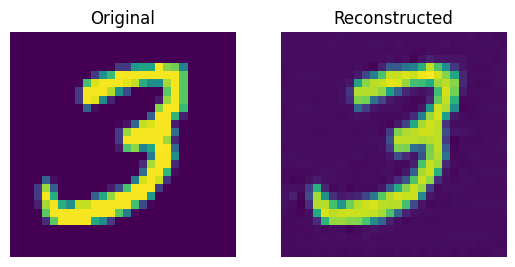

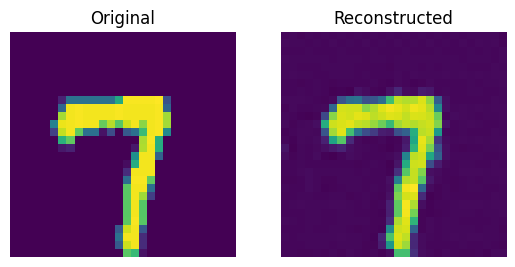

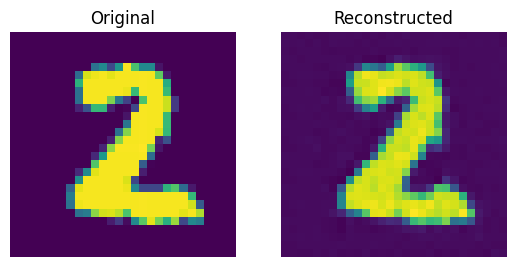

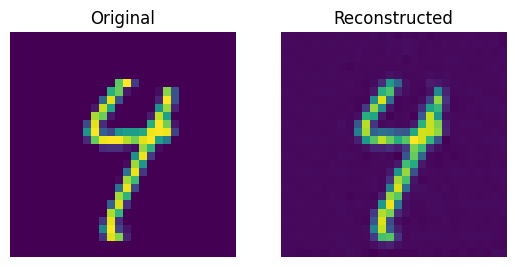

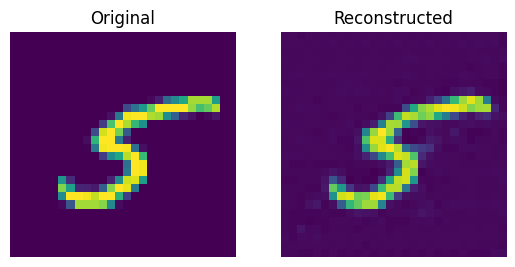

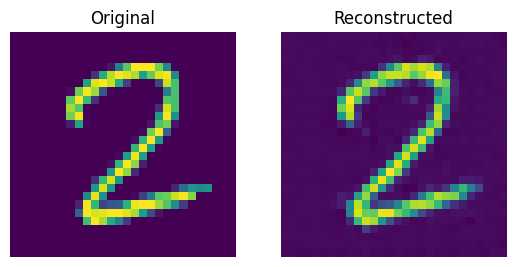

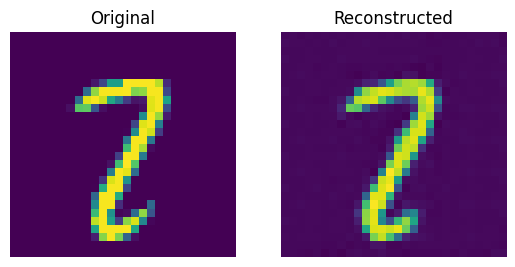

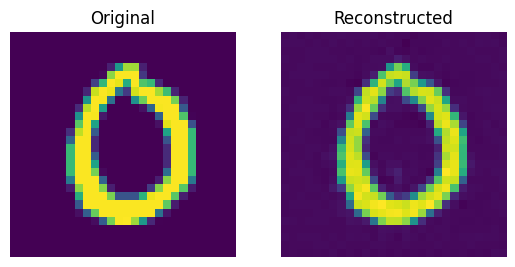

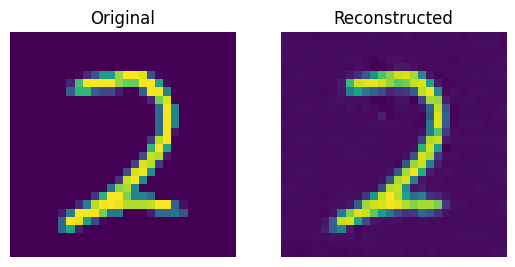

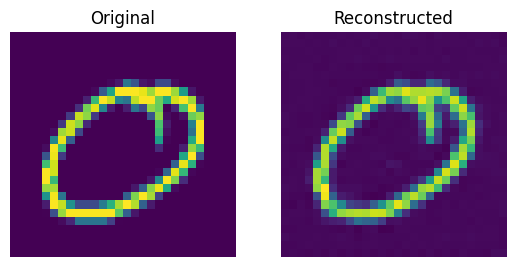

In [18]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

### Question 3 (Total 40 marks)

a) Design, implement and train a VQ-VAE for the spoken digit dataset. You are free to choose any architecture for the encoder and decoder networks, but your model should use the custom RVQ layer from question 2, with $N_q\ge2$ codebooks. (If you have been unable to implement this custom layer, then you should use the `VectorQuantizer` layer from the [Keras website](https://keras.io/examples/generative/vq_vae/)). You can also make additions or modifications to the training algorithm if you wish.

Your trained model should output a sequence of codebook vectors using the encoder and RVQ layer, which are then decoded by the decoder network to reconstruct the original input.

You should record any experiments you carry out along with the training logs, to be reported in question 4. Your code in this question does not need to be presented so that it runs all experiments, it can be set out to run the best experiment only.

Display some examples (playable using the `Audio` class from the `IPython.display` module as in question 1) from the dataset along with their reconstructions to demonstrate the trained model.

**(25 marks)**

We will need to create a few custom layers to handle the masking of padding values in the inputs.

In [ ]:
#RAVE: A variational autoencoder for fast and high-quality neural audio synthesis
#https://www.kaggle.com/code/basu369victor/generate-music-with-variational-autoencoder

In [ ]:
#https://yuehan-z.medium.com/introduction-to-vaes-in-ai-music-generation-d8e0cfc2245b

In [17]:
from tensorflow.keras import layers
from tensorflow import keras
#spec[...,tf.newaxis]
#elem_extended = elem[...,tf.newaxis]


def get_encoder2(latent_dim=16):
    encoder_inputs = keras.Input(shape=(18264, 1))
    x = layers.Conv1D(32, 3, activation="relu", strides=2, padding="same")(
            encoder_inputs
        )
    x = layers.Conv1D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv1D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder2(latent_dim=16):
    #decoder_inputs = keras.Input(shape=(4566, 16))
    latent_inputs = keras.Input(shape=get_encoder2(latent_dim).output.shape[1:])
    x1 = layers.Conv1DTranspose(64, 2, activation="relu", strides=2, padding="same")(latent_inputs)
    x2 = layers.Conv1DTranspose(32, 3, activation="relu", strides=2, padding="same")(x1)
    decoder_outputs = layers.Conv1DTranspose(1, 3, padding="same")(x2)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


def get_vqvae2(num_embeddings=64, latent_dim=16):
    encoder_inputs = keras.Input(shape=(18264, 1))
    encoder = get_encoder2(latent_dim=16)
    decoder = get_decoder2(latent_dim=16)
    vq_layer = RVQVectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder_outputs = encoder(encoder_inputs)
    quantized_latents = vq_layer(encoder_outputs)
    decoder_outputs = decoder(quantized_latents)
    return keras.Model(encoder_inputs, outputs=decoder_outputs , name="vq_vae"), encoder, vq_layer, decoder

In [60]:
num_embeddings=128
latent_dim= 16
vqvae, encoder, vq_layer, decoder = get_vqvae2(latent_dim, num_embeddings)
for x in train_dataset.take(1):
    a = vq_layer(encoder(x))

In [61]:
class VQVAETrainer2(keras.models.Model):
    def __init__(self, train_variance, latent_dim=16, num_embeddings=128,
                 **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae, self.encoder, self.vq_layer, self.decoder = get_vqvae2(self.num_embeddings, self.latent_dim)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) /\
                self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

    def test_step(self, data):

        # add losses for test case

        x = data
        reconstructions = self.vqvae(x)
        reconstruction_loss = tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
        total_loss = reconstruction_loss + sum(self.vqvae.losses)

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [62]:
data_variance

0.09493041879725218

In [63]:
data_variance_nopadding

0.01663708

In [64]:
def reconstruction_loss(y_true, y_pred):
    return -y_pred.log_prob(y_true)

vqvae_trainer = VQVAETrainer2(data_variance_nopadding, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam(),
                      loss=reconstruction_loss, metrics=['accuracy'])
#vqvae_trainer.compile(optimizer=tf.keras.optimizers.Adam(0.0005))
#vqvae_trainer.fit(train_data, epochs=100, validation_data=val_data,
#                  callbacks = [early_stopping])

history = vqvae_trainer.fit(train_dataset,
                            validation_data=val_dataset,
                            epochs=30,
                            batch_size=64)

Epoch 1/30
24/24 [==============================] - 8s 230ms/step - loss: 12.4336 - reconstruction_loss: 8.1411 - vqvae_loss: 0.0031 - val_loss: 0.5755 - val_reconstruction_loss: 0.5249 - val_vqvae_loss: 0.0506
Epoch 2/30
24/24 [==============================] - 5s 199ms/step - loss: 0.8484 - reconstruction_loss: 0.7495 - vqvae_loss: 0.0607 - val_loss: 0.5971 - val_reconstruction_loss: 0.5760 - val_vqvae_loss: 0.0211
Epoch 3/30
24/24 [==============================] - 5s 215ms/step - loss: 0.5186 - reconstruction_loss: 0.4536 - vqvae_loss: 0.0237 - val_loss: 0.4753 - val_reconstruction_loss: 0.4442 - val_vqvae_loss: 0.0311
Epoch 4/30
24/24 [==============================] - 5s 200ms/step - loss: 0.4504 - reconstruction_loss: 0.4146 - vqvae_loss: 0.0308 - val_loss: 0.4791 - val_reconstruction_loss: 0.4371 - val_vqvae_loss: 0.0420
Epoch 5/30
24/24 [==============================] - 5s 205ms/step - loss: 0.4551 - reconstruction_loss: 0.4075 - vqvae_loss: 0.0461 - val_loss: 0.4856 - val_re

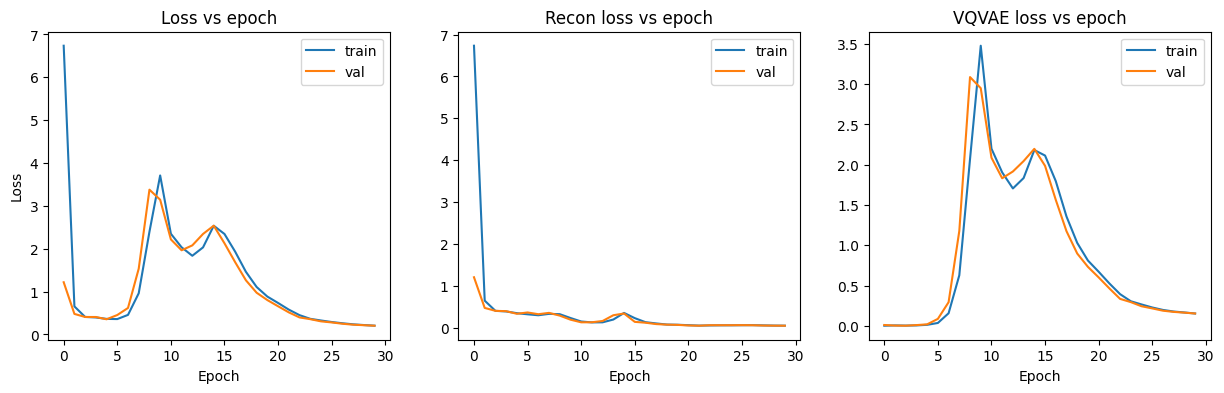

In [22]:
# Plot the learning curves

fig = plt.figure(figsize=(15, 4))
fig.add_subplot(1, 3, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs epoch")
plt.legend()

fig.add_subplot(1, 3, 2)
plt.plot(history.history['reconstruction_loss'], label='train')
plt.plot(history.history['val_reconstruction_loss'], label='val')
plt.xlabel("Epoch")
plt.title("Recon loss vs epoch")
plt.legend()

fig.add_subplot(1, 3, 3)
plt.plot(history.history['vqvae_loss'], label='train')
plt.plot(history.history['val_vqvae_loss'], label='val')
plt.xlabel("Epoch")
plt.title("VQVAE loss vs epoch")
plt.legend()

plt.show()

In [73]:
history.history.keys()

dict_keys(['loss', 'reconstruction_loss', 'vqvae_loss', 'val_loss', 'val_reconstruction_loss', 'val_vqvae_loss'])

In [78]:
for sample_test in test_dataset.take(6):
    sample_test


trained_vqvae_model = vqvae_trainer.vqvae
reconstructions_test = trained_vqvae_model.predict(sample_test)

2/2 [==============================] - 0s 69ms/step


In [79]:
tf.squeeze(reconstructions_test)[0]

Audio(tf.squeeze(reconstructions_test)[1],rate=8000)

b) The VQ-VAE quantisation layer emits a sequence of discrete codes for a given audio input. During training, the prior distribution over these codes is kept uniform. In order to use the model to generate audio, it is necessary to train a second model to predict likely sequences of codebook vectors.

This second model is usually referred to in the literature as a 'prior' model (note that this is not really a prior, as it is trained on the data). We will adopt this same terminology here.

You should design, implement and train a prior model to generate sequences of codebook vectors, using the output of the trained VQ-VAE encoder and quantisation stage, using the same training data that was used to train the VQ-VAE. You are again free to choose any architecture for the prior model.

Your trained model should generate a sequence that can be decoded by the VQ-VAE to output audio.

You should record any experiments you carry out along with the training logs, to be reported in question 4. Your code in this question does not need to be presented so that it runs all experiments, it can be set out to run the best set of hyperparameters, according to your validation results. You should aim to try at least two sets of hyperparameters.

Display some examples (playable using the Audio class from the IPython.display module as in question 1) generated using your prior and VQ-VAE model.

**(15 marks)**

In [ ]:
# causal mask on conv1d
# dilated kernels
# plot reconstruction on top of each other - normalize and plot
# FiLM layer to perform denoising
# use an rnn for the last part
# masking not handled in this implementation
# look into early stopping



# how to get the data variance
# the training pipeline will mutate the objects (encoder)

# report:
#   hyper-parameter tuning
#   start with simple model
#   then complexify the model
#   by reading these papers

# random restart or dropouts

In [50]:
decoder = vqvae_trainer.decoder

In [23]:
vq_layer = vqvae_trainer.vq_layer

In [24]:
vq_layer.embedding_dim

16

In [25]:
vq_layer.num_embeddings

128

In [26]:
encoder = vqvae_trainer.encoder
vq_layer = vqvae_trainer.vq_layer


def get_code_indices(flattened_inputs, embeddings):
    # Calculate L2-normalized distance between the inputs and the codes.
    similarity = tf.matmul(flattened_inputs, embeddings)
    distances = (
        tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
        + tf.reduce_sum(embeddings ** 2, axis=0)
        - 2 * similarity
    )
    # Derive the indices for minimum distances.
    encoding_indices = tf.argmin(distances, axis=1)
    return encoding_indices

def get_encoding_indices(elem):
    encoder_output = encoder(elem)
    end_shape = tf.shape(encoder(elem))[0:2]
    flattened = tf.reshape(encoder_output, [-1, vq_layer.embedding_dim])
    encoding_indices_flat = get_code_indices(flattened,
                                             vq_layer.embeddings[-1])
    return tf.reshape(encoding_indices_flat,end_shape)


train_codebooks = train_dataset.map(get_encoding_indices)
val_codebooks = val_dataset.map(get_encoding_indices)
test_codebooks = val_dataset.map(get_encoding_indices)

In [27]:
train_cb_list   = []
val_cb_list     = []
test_cb_list    = []
for elem in train_codebooks:
    train_cb_list.append(elem.numpy())
for elem in val_codebooks:
    val_cb_list.append(elem.numpy())
for elem in test_codebooks:
    test_cb_list.append(elem.numpy())

In [30]:
train_cb_onematrix  = np.concatenate(train_cb_list)
val_cb_onematrix    = np.concatenate(val_cb_list)
test_cb_onematrix   = np.concatenate(test_cb_list)

In [31]:
np.unique(train_cb_onematrix)

array([  5,  43,  46,  48,  96, 102, 105, 119, 123])

In [32]:
len(np.unique(train_cb_onematrix))

9

In [33]:
train_slice_cb = tf.data.Dataset.from_tensor_slices(train_cb_onematrix)
val_slice_cb = tf.data.Dataset.from_tensor_slices(val_cb_onematrix)
test_slice_cb = tf.data.Dataset.from_tensor_slices(test_cb_onematrix)

for element in train_slice_cb.take(1):
  print(element)

tf.Tensor([43 43 43 ... 43 43 43], shape=(4566,), dtype=int64)


In [34]:
def inputs_and_targets(batch):
    inputs = batch[:-1]
    targets = batch[1:]
    return inputs, targets

train_ds_ar = train_slice_cb.map(inputs_and_targets).batch(64)
val_ds_ar   = val_slice_cb.map(inputs_and_targets).batch(64)
test_ds_ar  = test_slice_cb.map(inputs_and_targets).batch(64)

In [35]:
for elem in val_ds_ar.take(1):
    print(elem[0].shape)

(64, 4565)


In [41]:
def get_model(vocab_size, embedding_dim, gru_units):
    """
    This function takes a vocabulary size and batch size, and builds and returns a
    Sequential model according to the above specification.
    """

    inputs = tf.keras.layers.Input(shape=(None,), name="token_input")
    embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                          mask_zero=True, name='embedding')(inputs)
    h, state = tf.keras.layers.GRU(units=gru_units, return_sequences=True,
                                   return_state=True, name='gru')(embedding)
    preds = tf.keras.layers.Dense(vocab_size, name='preds')(h)
    model = tf.keras.Model(inputs=inputs, outputs=[preds, state])

    losses = [
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        None
    ]
    model.compile(optimizer='adam',
                  metrics=[['sparse_categorical_accuracy'], []],
                  loss=losses)
    return model


rnn_model = get_model(vocab_size = vq_layer.num_embeddings, embedding_dim = 16, gru_units = 1024)
rnn_model.summary()

history = rnn_model.fit(train_ds_ar, validation_data=val_ds_ar, epochs=15,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_input (InputLayer)    [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 16)          2048      
                                                                 
 gru (GRU)                   [(None, None, 1024),      3201024   
                              (None, 1024)]                      
                                                                 
 preds (Dense)               (None, None, 128)         131200    
                                                                 
Total params: 3334272 (12.72 MB)
Trainable params: 3334272 (12.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15


CancelledError: Graph execution error:

Detected at node broadcast_weights_2/assert_broadcastable/AssertGuard/pivot_f/_15/_49 defined at (most recent call last):
<stack traces unavailable>
RecvAsync is cancelled.
	 [[{{node broadcast_weights_2/assert_broadcastable/AssertGuard/pivot_f/_15/_49}}]] [Op:__inference_train_function_43994]

In [37]:
# use the same model as before, but returns losses so that values are not evaluated on the final state output
# just part of the tensorflow model - using example from week 6 formative assessment

def get_model(sequence_dim :int, embedding_dim: int, gru_units:int):
    """
    This function takes a sequence length and batch size, and builds and returns a
    Sequential model according to the above specification.

    Specifying the embedding dim and the gru_units
    """

    # 1. create the model using the functional api

    # MAKE SURE TO SET MASK_ZERO OTHERWISE YOU WILL GET SOME WEIRD ERRORS!

    inputs = tf.keras.layers.Input(shape = (None,), name = "sequence_input")
    embedding = tf.keras.layers.Embedding(input_dim=sequence_dim, output_dim = embedding_dim,
                                          mask_zero = True, name = 'embedding'
                                         )(inputs)

    # pass embedding to get richer sequence for our layers for our code book sequences

    # matrix setting for how many words, and how many out
    # this actually takes the sparse representation and not the one-hot one unlike what was discussed in deep learning.

    h, state = tf.keras.layers.GRU(units = gru_units, return_sequences=True,
                                  return_state = True, name = "gru")(embedding)

    # ADD OTHER LAYERS HERE FOR THE WORKFLOW

    # define the final output layer
    # final layer must match with vocab size here for sequence prediction

    # hence we need a softmax here, but we can have raw logit, and set loss as True here.
    preds = tf.keras.layers.Dense(sequence_dim, name = 'preds_sequence')(h)
    # link input and outputs
    model = tf.keras.Model(inputs = inputs, outputs = [preds, state])

    # 2. compile the model, with model losses and metrics
    # since we have a the states returned, we don't want to evaluate on the second state, therefore we put list of lists here, to skip the second case
    # REMEMBER THIS HACK!!
    losses = [
        # to change loss settings, you have to use the objects and not the string input remember this!!
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        None
    ]
    model.compile(optimizer='adam',
                 metrics = [['sparse_categorical_accuracy'],[]],
                 loss = losses)

    return model

In [38]:
rnn_model = get_model(sequence_dim = 128, embedding_dim = 64, gru_units = 256)
rnn_model.summary()

history = rnn_model.fit(train_ds_ar, validation_data=val_ds_ar, epochs=10,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequence_input (InputLayer  [(None, None)]            0         
 )                                                               
                                                                 
 embedding (Embedding)       (None, None, 64)          8192      
                                                                 
 gru (GRU)                   [(None, None, 256),       247296    
                              (None, 256)]                       
                                                                 
 preds_sequence (Dense)      (None, None, 128)         32896     
                                                                 
Total params: 288384 (1.10 MB)
Trainable params: 288384 (1.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
24/24 [=======

In [40]:
history.history

{'loss': [3.1538538932800293,
  0.9298597574234009,
  0.4524767994880676,
  0.2266591191291809,
  0.187229186296463,
  0.176707923412323,
  0.17136110365390778,
  0.16746993362903595,
  0.16372473537921906,
  0.16043855249881744],
 'preds_sequence_loss': [3.1538538932800293,
  0.9298597574234009,
  0.4524767994880676,
  0.2266591191291809,
  0.187229186296463,
  0.176707923412323,
  0.17136110365390778,
  0.16746993362903595,
  0.16372473537921906,
  0.16043855249881744],
 'preds_sequence_sparse_categorical_accuracy': [0.5935733914375305,
  0.6577492356300354,
  0.9176137447357178,
  0.9420822262763977,
  0.9429320096969604,
  0.9440844058990479,
  0.9447509050369263,
  0.9451852440834045,
  0.9456417560577393,
  0.9459441900253296],
 'val_loss': [1.1360148191452026,
  0.6964565515518188,
  0.2722725570201874,
  0.18925951421260834,
  0.17344912886619568,
  0.16747930645942688,
  0.16358311474323273,
  0.15991796553134918,
  0.15669560432434082,
  0.15406326949596405],
 'val_preds_sequ

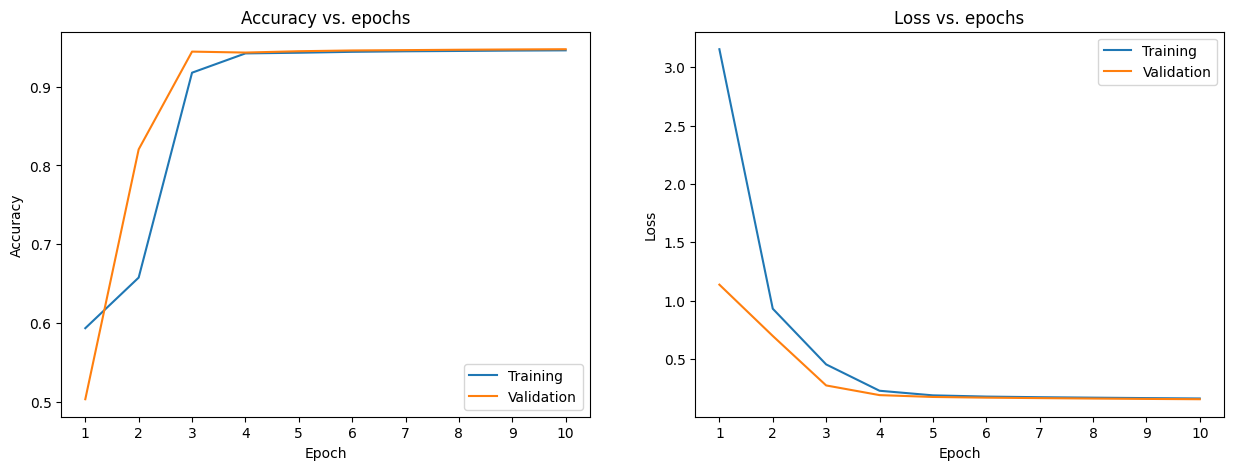

In [41]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history.history['preds_sequence_sparse_categorical_accuracy'])
plt.plot(history.history['val_preds_sequence_sparse_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history.history['preds_sequence_sparse_categorical_accuracy'])))
ax = plt.gca()
ax.set_xticklabels(1 + np.arange(len(history.history['preds_sequence_sparse_categorical_accuracy'])))
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history.history['preds_sequence_sparse_categorical_accuracy'])))
ax = plt.gca()
ax.set_xticklabels(1 + np.arange(len(history.history['preds_sequence_sparse_categorical_accuracy'])))
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [46]:


for elem in test_ds_ar:
    input_codebook = elem

In [52]:

a_test_codebook = input_codebook[0][0]
max_lengtb = a_test_codebook.shape#input_codebook[0][0][0:500]

In [55]:
a_test_codebook.shape

TensorShape([4565])

In [59]:
sound_max_length_padded/2/2

4566.0

In [44]:
def sample_token(model, token_sequence, initial_state=None):
    """
    This function takes a model object, a token sequence and an optional initial
    state for the recurrent layer. The function should return the logits prediction
    for the final time step as a 2D numpy array.
    """
    h = token_sequence
    updated_state = None
    for i, layer in enumerate(model.layers):
        if i == 2:
            h, updated_state = layer(h, initial_state=initial_state)
        else:
            h = layer(h)
    final_step = h[:, -1, :]  # (batch_size, num_tokens)
    print("final_step")
    print(final_step)
    samples = tf.random.categorical(final_step, 1)  # (batch_size, 1)
    return samples, updated_state

samples, updated_state = sample_token(rnn_model, tf.constant([[30, 2, 24], [16, 12, 33]]))


def generate_codebook(model, input_codebook, num_generation_steps,
                  num_embeddings=128, sample_token=sample_token):
    """
    This function takes a model object, a seed string, a TextVectorization object and a
    number of steps to generate characters as arguments. It should generate text
    according to the above directions and return the extended string.
    """
    token_sequence = input_codebook[tf.newaxis, ...]  # (1, seq_length)
    input_sequence = token_sequence
    initial_state = None
    for _ in range(num_generation_steps):
        sample, updated_state = sample_token(model, input_sequence, initial_state=initial_state)
        token_sequence = tf.concat((token_sequence, sample), axis=1)
        input_sequence = sample
        initial_state = updated_state

    inx_to_chars = {i: c for i, c in enumerate(num_embeddings)}
    final_token_sequence = tf.squeeze(token_sequence).numpy()
    final_char_sequence = [inx_to_chars[token] for token in final_token_sequence]
    return ''.join(final_char_sequence)



generate_codebook(rnn_model, input_codebook[0][0], input_codebook[0][0][0:500])

final_step
tf.Tensor(
[[-0.51584977 -0.74608535 -0.64253724 -0.6641104  -0.66327095  0.60980093
  -0.6565732  -0.5570145  -0.6425699  -0.74379563 -0.65064627 -0.6877719
  -0.67096436 -0.749628   -0.59307754 -0.6011948  -0.60611916 -0.6200099
  -0.6602815  -0.629332   -0.53270465 -0.5509834  -0.5385923  -0.597371
  -0.7434466  -0.6641562  -0.6371454  -0.6316364  -0.6304351  -0.6845878
  -0.61953443 -0.7466372  -0.6854766  -0.6453235  -0.6377982  -0.5530901
  -0.60321456 -0.65476245 -0.61350775 -0.56375426 -0.5399565  -0.69180655
  -0.70244503  0.9953867  -0.5093978  -0.62046087 -0.29331356 -0.6640656
   0.3621447  -0.5915604  -0.5789964  -0.49914926 -0.69530815 -0.7030347
  -0.6728051  -0.703291   -0.56697106 -0.54858756 -0.5985011  -0.6276893
  -0.794894   -0.6158281  -0.5745358  -0.5065898  -0.59927917 -0.6421751
  -0.5831351  -0.5798432  -0.6793601  -0.69219244 -0.605      -0.603564
  -0.6598311  -0.6621568  -0.6196338  -0.6804275  -0.65552    -0.6242378
  -0.67355907 -0.6799901  -0.

### Question 4 (Total 15 marks)

Provide a separate PDF report with an account of the models and experiment design you have made in question 3. Your report should include details of the choices you have made throughout the development of the models, including the data processing, architecture design, hyperparameter settings/experiments and training algorithm. Where appropriate, you can also provide your intuition behind these choices.

Your report should also include the results from your experiments, highlighting the best choice of hyperparameters that you found. If you encountered difficulties to successfully train the model(s) you should report these, and if possible suggest what you think might be potential reasons for these difficulties. Are there additional experiments or modifications to the model and/or training algorithm that you would have liked to make given more time?

Marks will be awarded for presentation and clarity. Your report should be no more than 2-3 pages.

**(15 marks)**